In [1]:
import ROOT
from larlite import *

In [2]:
from ROOT import hit,box,PandoraNuTrack,GENIEinteraction,pairVertex,AnalyseEvents

In [3]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import sys; sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/CCQEana/CCQEPackage/notebooks/'); sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/mySoftware/MySoftwarePackage/mac/');
from plot_tools import *
from ccqe_notebook_tools import *
import matplotlib.colors as colors, matplotlib.patches as patches
from matplotlib.ticker import NullFormatter

In [4]:
%matplotlib inline
# %matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
def get_tracks_hits_vertices( ana=None, entry=0 , debug=0 ):
    if ana is None: 
        print "ana is None! returning..."
        return
    ana.GetEntry( entry )
    tracks = ana.GetTracks()
    hits = ana.GetHits()
    vertices = ana.GetVertices()
    if debug:
        print '%d track, %d hits, %d vertices'%(int(tracks.size()),int(hits.size()),int(vertices.size()))
    for v in vertices:
        print 'vertex',v.GetVertexID(),':',v.GetTruthTopologyString()
    return hits,tracks,vertices

In [6]:
#---------------------------------------------------------------------------------------------
def plot_tracks(hits,plane,ax=None,cmap='hot_r',color='',do_add_numbers=False, do_add_text=False):
    for t in tracks:
        color, label,_ = set_color_label_cmap(t)
        w_start , t_start , w_end , t_end = t.GetStartWire(plane) , t.GetStartTime(plane) , t.GetEndWire(plane) , t.GetEndTime(plane)
        plt.plot([w_start,w_end],[t_start,t_end],color=color)
        if do_add_text: plt.text(w_start + 0.3*(w_end-w_start), t_start, label,color=color,fontsize=20)
#---------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,cmap='hot_r',do_add_hit_trkKey=False,do_add_numbers=False,color=None
              ,tracks=None):
    
    hit_wire, hit_time, hit_charge , hit_number , hit_trkKey, hit_color = [] , [] , [] , [] , [], []
    hits_df=pd.DataFrame({})
    associated_hits=dict()
    for i_hit,hit in enumerate(hits):
        if hit.InPlane(plane):# and hit_in_box(hit,box=box):
            hit_wire.append(hit.GetWire())
            hit_time.append(hit.GetPeakT())
            hit_charge.append(hit.GetCharge())
    ax.scatter(hit_wire,hit_time,c=hit_charge if color is None else color
               ,vmin=np.min(hit_charge), vmax=np.max(hit_charge),s=20, cmap='hot_r' )
#---------------------------------------------------------------------------------------------

# ------------------------------------------------
def find_hit_color(hit_trkKey=None,tracks=None):
    if tracks is None: return 'purple'
    for t in tracks:
        if t.GetTrackID() == hit_trkKey:
            color,_,_ = set_color_label_cmap(t)
            return color
    return 'white'
# ------------------------------------------------

# prodgenie_bnb_nu_uboone_overlay_reco2

In [27]:
file=ROOT.TFile("/Users/erezcohen/Desktop/uBoone/CCQEanalysis/EventsFiles/prodgenie_bnb_nu_uboone_overlay_reco2_events.root")
tree=file.Get("EventsAnalyzer/eventsTree")
ana=AnalyseEvents(tree)

In [28]:
hits , tracks , vertices = get_tracks_hits_vertices( ana, entry=33 , debug=True )

14 track, 9988 hits, 3 vertices
vertex 0 : cosmic pair
vertex 1 : cosmic pair
vertex 2 : true CC 1p 0π


In [11]:
#---------------------------------------------------------------------------------------------    
def draw_vertex( hits=None, tracks=None , vertex=None, do_add_legend=False, planes=[0,1,2],
                do_add_RdQaroundVertex=False, box_dimesions=(20,40)  ):
    
    fig=plt.figure(figsize=(28,8))
    for plane in planes:
        ax=fig.add_subplot(1,3,plane+1)        
        # hits
        plot_hits(hits , plane=plane , ax=ax , cmap='hot_r' )
        # tracks
        plot_tracks(tracks , plane=plane , ax=ax , do_add_text=False )
        # vertex
        plot_vertex(vertex , plane=plane , ax=ax )
        
        # get RdQ around vertex for a given box size
        if do_add_RdQaroundVertex:
            getRdQaroundVertex(vertex=vertex, ax=ax , plane=plane, hits=hits , box_dimesions=box_dimesions)

        
        # style 
        if do_add_legend and plane==2: ax.add_legend(bbox_to_anchor(1,1.05),loc=2,fontsize=20)
        if plane>0: ax.yaxis.set_major_formatter( NullFormatter() )
        set_axes(ax,'wire','time tick' if plane==0 else '',xticks=np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),5))
#---------------------------------------------------------------------------------------------            

#---------------------------------------------------------------------------------------------
def plot_vertex(vertex=None , plane=0 , ax=None , roi_dimesions = [100,200]):
    
    # draw ROI   
    add_vertex_ROI( vertex=vertex , ax=ax , plane=plane , roi_dimesions=roi_dimesions , color='salmon' , alpha=0.25)
    # hits associated with the muon and proton tracks
    muon_hits = vertex.GetMuonHits(plane)
    proton_hits = vertex.GetProtonHits(plane)
    ax.set_xlim(np.min(np.concatenate([[h.GetWire() for h in muon_hits],[h.GetWire() for h in proton_hits]]))-roi_dimesions[0]
                ,np.max(np.concatenate([[h.GetWire() for h in muon_hits],[h.GetWire() for h in proton_hits]]))+roi_dimesions[0])
    ax.set_ylim(np.min(np.concatenate([[h.GetPeakT() for h in muon_hits],[h.GetPeakT() for h in proton_hits]]))-roi_dimesions[1]
                ,np.max(np.concatenate([[h.GetPeakT() for h in muon_hits],[h.GetPeakT() for h in proton_hits]]))+roi_dimesions[1])
    # plots hits associated with the muon and proton tracks
    plot_hits( muon_hits , plane=plane , ax=ax , color='black')        
    plot_hits( proton_hits , plane=plane , ax=ax , color='blue') 
    
#---------------------------------------------------------------------------------------------    

In [12]:
#---------------------------------------------------------------------------------------------    
def add_vertex_ROI( vertex=None , ax=None , plane=0 , roi_dimesions=None , color='black', alpha=0.8):
    wire,time = vertex.GetVertexWire(plane),vertex.GetVertexTime(plane)
    ax.add_patch(patches.Rectangle( (wire-roi_dimesions[0]/2,time-roi_dimesions[1]/2),   # (x,y)    
                                   roi_dimesions[0],          # width                                   
                                   roi_dimesions[1],         # height                                   
                                   fill=False,   # remove background                                   
                                   color=color ,
                                   linewidth=2,
                                   alpha=alpha
                                  ))   
    return wire,time
#---------------------------------------------------------------------------------------------        

In [13]:
#---------------------------------------------------------------------------------------------    
def get_toal_charge_in_box( hits=None , plane=0 , box_around_vertex=None ):
    Q=0.0
    for h in hits:
        if h.InPlane(plane) and h.InBox( box_around_vertex ):
            Q = Q + h.GetCharge()  
    return Q
#---------------------------------------------------------------------------------------------        

In [22]:
#---------------------------------------------------------------------------------------------    
def getRdQaroundVertex(vertex=None, ax=None , plane=0, hits=None , box_dimesions=None):
    wire,time = add_vertex_ROI( vertex=vertex , ax=ax , plane=plane, roi_dimesions=box_dimesions , color='black' )
    box_around_vertex = box( wire-box_dimesions[0]/2 , time-box_dimesions[1]/2 , 
                             wire+box_dimesions[0]/2 , time+box_dimesions[1]/2 )
    Qtotal = get_toal_charge_in_box( hits=hits , plane=plane , box_around_vertex=box_around_vertex )
    Qmuon = get_toal_charge_in_box( hits=vertex.GetMuonHits(plane) , plane=plane , box_around_vertex=box_around_vertex )
    Qproton = get_toal_charge_in_box( hits=vertex.GetProtonHits(plane) , plane=plane , box_around_vertex=box_around_vertex )
    # print 'Qtotal,Qmuon,Qproton:',Qtotal,Qmuon,Qproton
    RdQ = (Qmuon+Qproton)/Qtotal if np.abs(Qtotal)>0 else 0
    print 'plane',plane,'Q(tracks)/Q(total):',RdQ
    # print 'and the vertex function:',vertex.GetRdQaroundVertex( plane , box_dimesions[0], box_dimesions[1] , hits )
#---------------------------------------------------------------------------------------------    

plane 0 Q(tracks)/Q(total): 0.726659549108
plane 1 Q(tracks)/Q(total): 1.0
plane 2 Q(tracks)/Q(total): 0.960239768206


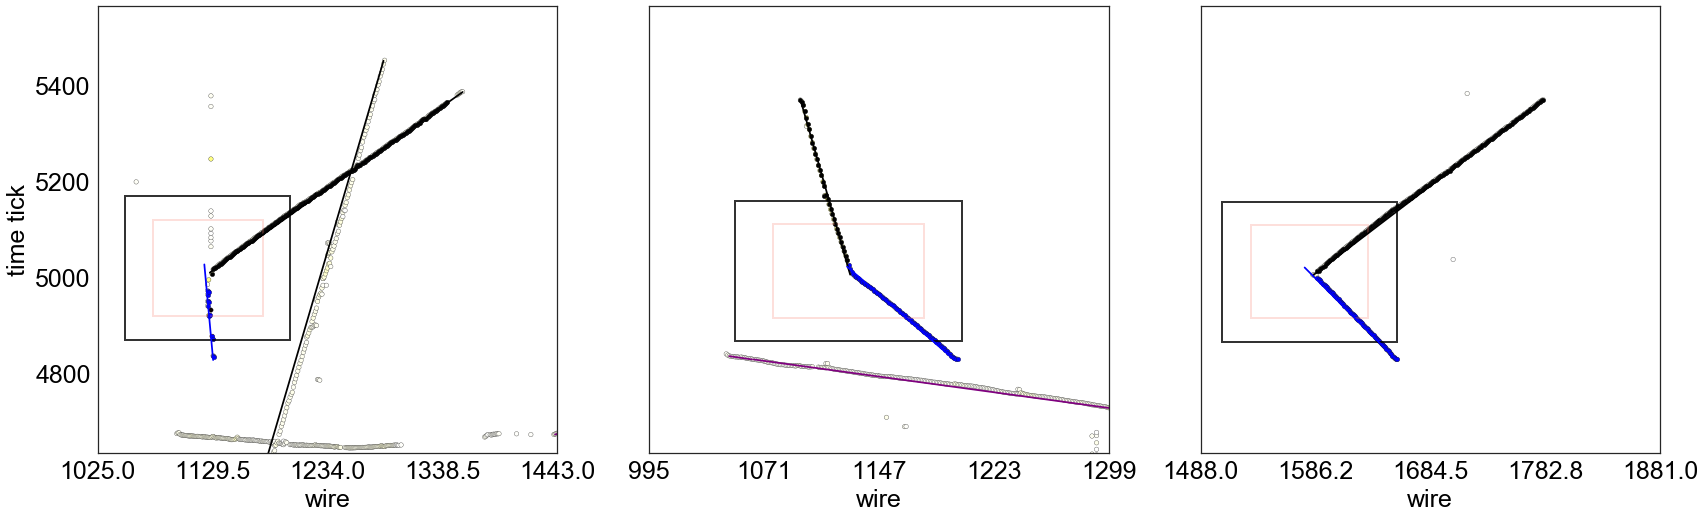

In [30]:
draw_vertex( hits , tracks , vertices.at(2) , planes=[0,1,2] 
            , do_add_RdQaroundVertex=True , box_dimesions=(150,300) )